### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [2]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.patches import PathPatch

import shutil


import cv2
from shapely.geometry import LineString
import time

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [3]:
# Global variables

IMAGE_DIR = 'test_images_1/extracted_images'
IMAGE_NAME='B159M-L1-YK-0001_MEprobe_OCT_z_58_export_fig_page1'
MASK = [0, 364, 0, 364] # ymin ymax xmin xmax

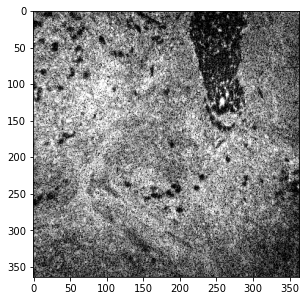

In [4]:
x=iio.imread(IMAGE_DIR+"/"+IMAGE_NAME+".png")

plt.imshow(x)

Image name (shape) (intensity max, min, mean, std)

B159M-L1-YK-0001_MEprobe_OCT_z_58_export_fig_page1 (364, 364, 3) (255, 0, 120.8, 65.1)


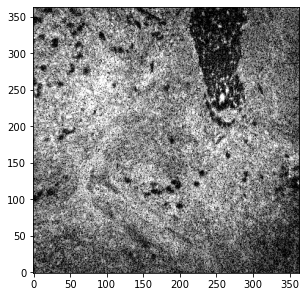

In [5]:
# Read, crop and display image and stats
def crop (image, mask):
    h, w = image.shape[0], image.shape[1]
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

def square_off_image(image, target_size=256):
    """
    Stretches the input image to make it a square by resizing it.

    Args:
        image (np.ndarray): Input image.
        target_size (int): The size of the square image (default: 256x256).

    Returns:
        np.ndarray: Stretched square image.
    """
    # Resize the image to the target square size
    return cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_LINEAR)

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [6]:
import time

start_time = time.time()
function_times = {}

def measure_time(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        function_time = te - ts
        
        if f.__name__ not in function_times:
            function_times[f.__name__] = [0, 0]  # [total_time, call_count]
        function_times[f.__name__][0] += function_time
        function_times[f.__name__][1] += 1
        
        return result
    
    return timed

def print_function_times():
    end_time = time.time()
    total_program_time = end_time - start_time
    
    print()
    print("### PROFILING ###")
    print("Total program time: {:.2f} sec".format(total_program_time))
    print("Function times:")
    for function_name, (total_time, call_count) in function_times.items():
        percentage = (total_time / total_program_time) * 100
        average_time = total_time / call_count
        print("- {}: {:.2f} sec ({:.2f}%), {} calls".format(
            function_name, total_time, percentage, call_count, average_time))
    print()

In [15]:
class Camo_Cell:
    def __init__(self, x, y, gray_value):
        self.x = x
        self.y = y
        self.gray_value = gray_value  # Store grayscale intensity

    def draw(self, ax):
        """Draws the 2x2 pixel grayscale circle on a Matplotlib plot."""
        circle = plt.Circle((self.x, self.y), 4, color=(self.gray_value, self.gray_value, self.gray_value), ec='black', lw=0.1)
        ax.add_patch(circle)

    def colour_from_image(self, image):
        """Samples grayscale intensity from an image at (x, y)."""
        height, width = image.shape[:2]
        x = int(np.clip(self.x, 0, width - 1))
        y = int(np.clip(self.y, 0, height - 1))
        gray = image[y, x] / 255.0  # Normalize grayscale
        self.gray_value = gray  # Store grayscale intensity


In [8]:
class Drawing:
    def __init__(self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0], point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0], points[1]), radius, **kwargs))

    def add_worms(self, worms, alpha=1.0):
        try:
            for worm in worms:
                patch = worm.patch()
                patch.set_alpha(alpha)
                self.ax.add_patch(patch)
        except TypeError:
            patch = worms.patch()
            patch.set_alpha(alpha)
            self.ax.add_patch(patch)

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [9]:
def random_cell(imshape):
    """Generates a random Camo_Cell with a grayscale value."""
    (ylim, xlim) = imshape
    x = np.random.uniform(0, xlim)  # Random x position
    y = np.random.uniform(0, ylim)  # Random y position
    gray_value = np.random.uniform(0, 1)  # Random grayscale intensity

    return Camo_Cell(x, y, gray_value)


In [10]:
# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_cell(imshape[:2], init_params))
    return clew

In [11]:
import numpy as np

class Fitness:
    def __init__(self, image, swarms):
        self.image = image
        self.swarms = swarms

    def get(self, cell):
        img_height, img_width = self.image.shape[:2]

        # Internal fitness: Ensures the cell stays within image bounds
        def internal_fitness():
            if 0 <= cell.x < img_width and 0 <= cell.y < img_height:
                return 1  # Good fitness
            return -10  # Heavy penalty if out of bounds

        # Group fitness: Encourages some spread between cells
        def group_fitness():
            min_distance = float('inf')
            for swarm in self.swarms:
                for other_cell in swarm.population:
                    if other_cell != cell:
                        distance = np.sqrt((cell.x - other_cell.x) ** 2 + (cell.y - other_cell.y) ** 2)
                        min_distance = min(min_distance, distance)
            
            if min_distance > 5:  
                return 1  # Well-spaced
            return -1  # Penalized if too close

        # Environmental fitness: Encourages matching background color
        def environmental_fitness():
            x, y = int(cell.x), int(cell.y)
            background_gray = self.image[y, x] / 255.0  # Normalize grayscale
            return 1 - abs(cell.gray_value - background_gray)  # Higher score for similar shades

        # Weights for each component
        Wi, Wg, We = 1, 1, 2  # More emphasis on environment blending

        # Calculate fitness
        fitness = (Wi * internal_fitness()) + (Wg * group_fitness()) + (We * environmental_fitness())
        return fitness


In [12]:
import random
import copy
import numpy as np

class Swarm:
    def __init__(self, image, population):
        self.image = image
        self.population = population
        self.fitness = None  # Must be set after initializing the Fitness class

        # Constants
        self.tnm_k = 3  # Tournament size for selection
        self.m_rate = 0.015  # Mutation rate

    @measure_time
    def update(self):
        assert self.fitness is not None, "Fitness must be set before updating the swarm."

        fitnesses = [self.fitness.get(cell) for cell in self.population]
        new_population = []
        size = len(self.population)

        img_height, img_width = self.image.shape[:2]

        for _ in range(size):
            # Tournament selection
            selected_ix = random.randint(0, size - 1)
            for ix in [random.randint(0, size - 1) for _ in range(self.tnm_k - 1)]:
                if fitnesses[ix] > fitnesses[selected_ix]:
                    selected_ix = ix

            parent = self.population[selected_ix]

            # Mutate position
            c_x = np.clip(parent.x + random.uniform(-self.m_rate * img_width, self.m_rate * img_width), 0, img_width - 1)
            c_y = np.clip(parent.y + random.uniform(-self.m_rate * img_height, self.m_rate * img_height), 0, img_height - 1)

            # Create child
            child = Camo_Cell(c_x, c_y, parent.gray_value)
            child.gray_value = parent.gray_value  # Apply mutated grayscale

            new_population.append(child)

        self.population = new_population

    @measure_time
    def avg_cell(self):
        """Computes the average cell position and grayscale value across the swarm."""
        avg = copy.deepcopy(self.population[0])
        avg.x = np.mean([cell.x for cell in self.population])
        avg.y = np.mean([cell.y for cell in self.population])
        avg.gray_value = np.mean([cell.gray_value for cell in self.population])
        return avg


In [16]:
import os
import time
import numpy as np
import cv2

# Directory containing the images and output
input_dir = "test_images_1/extracted_images"  # Folder with your background images
output_dir = "output_results_seq"
os.makedirs(output_dir, exist_ok=True)

# For profiling
start_time = time.time()
profiling = True  # Change to True to see function times

# Constants
iterations = 200
swarm_size = 10
num_swarms = 100
fps = 15  # Video frame rate

# Get list of image files
image_files = sorted([f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Initialize final worm population for continuity between images
final_worm_population = None

# Process each image
for img_idx, image_file in enumerate(image_files):
    print(f"Processing image {img_idx + 1}/{len(image_files)}: {image_file}")

    # Read image
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    if image is None:
        print(f"Error loading image: {image_file}")
        continue

    # Set up directory for saving frames of the current image
    frame_output_dir = os.path.join(output_dir, f"frames_image_{img_idx + 1}")
    os.makedirs(frame_output_dir, exist_ok=True)

    # Initialize swarms and fitness for the current image
    if final_worm_population is None:
        # Initialize the population for the first image
        swarms = [Swarm(image, [random_cell(image.shape) for _ in range(swarm_size)]) for _ in range(num_swarms)]
    else:
        # Carry over the final worm population to the next image
        assert len(final_worm_population) >= num_swarms * swarm_size, "Not enough worms for all swarms"
        new_population = [
            final_worm_population[i * swarm_size:(i + 1) * swarm_size]
            for i in range(num_swarms)
        ]
        swarms = [Swarm(image, pop) for pop in new_population]

    fitness = Fitness(image, swarms)
    for s in swarms:
        s.fitness = fitness

    # Main loop for iterations
    for it in range(iterations):
        for swarm in swarms:
            swarm.m_rate = 0.1 * np.exp(-3 * (it / iterations))
            swarm.tnm_k = max(int(len(swarm.population) / (1 + np.exp(-5 * (it / iterations - 0.8))) + 1), 2)
            swarm.update()

        # Save a frame for the overlaid image
        frame = np.copy(image)
        for swarm in swarms:
            avg_cell = swarm.avg_cell()
            cv2.circle(frame, (int(avg_cell.x), int(avg_cell.y)), 1, (int(avg_cell.gray_value * 255),), -1)

        frame_path = os.path.join(frame_output_dir, f"frame_{it + 1:04d}.png")
        cv2.imwrite(frame_path, frame)

    # Capture the final worm population for continuity to the next image
    final_worm_population = [cell for swarm in swarms for cell in swarm.population]

    # Create video for the current image
    print(f"Creating video for {image_file}...")
    frame_files = sorted([os.path.join(frame_output_dir, f) for f in os.listdir(frame_output_dir) if f.endswith(".png")])
    if not frame_files:
        print(f"No frames found for {image_file}. Skipping video creation.")
        continue
    first_frame = cv2.imread(frame_files[0], cv2.IMREAD_GRAYSCALE)
    height, width = first_frame.shape
    video_output_path = os.path.join(output_dir, f"video_image_{img_idx + 1}.mp4")
    video_writer = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), isColor=False)
    for frame_file in frame_files:
        frame = cv2.imread(frame_file, cv2.IMREAD_GRAYSCALE)
        video_writer.write(frame)
    video_writer.release()
    print(f"Video saved for {image_file} to {video_output_path}")

print("All images processed!")


Processing image 1/7: B159M-L1-YK-0001_MEprobe_OCT_z_58_export_fig_page1.png
Creating video for B159M-L1-YK-0001_MEprobe_OCT_z_58_export_fig_page1.png...
Video saved for B159M-L1-YK-0001_MEprobe_OCT_z_58_export_fig_page1.png to output_results_seq\video_image_1.mp4
Processing image 2/7: B159M-L1-YK-0002_MEprobe_OCT_z_58_export_fig_page1.png


KeyboardInterrupt: 